Dataset Overview:
   Ore_Studiu  Ore_Somn  Promovare
0        6.50      8.46          1
1        5.86      8.95          1
2        6.65      7.30          1
3        7.52      8.28          1
4        5.77      7.67          1

Class Distribution:
Promovare
1    0.5
0    0.5
Name: proportion, dtype: float64


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x792078c8f760>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so: cannot open shared object file: No such file or directory
Exception ignored on calling ctypes callback function: <function Thread

Output()

Output()

ERROR:pymc.stats.convergence:There were 2448 divergences after tuning. Increase `target_accept` or reparameterize.



Trace Summary:
             mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]     6.053  3.128     0.203     12.304      0.138    0.104     517.0   
beta[1]    10.605  3.745     4.272     17.996      0.177    0.130     467.0   
intercept   0.431  1.869    -3.082      4.276      0.080    0.057     542.0   
p[0]        1.000  0.001     0.999      1.000      0.000    0.000     734.0   
p[1]        0.000  0.000     0.000      0.000      0.000    0.000     559.0   
...           ...    ...       ...        ...        ...      ...       ...   
p[395]      1.000  0.000     1.000      1.000      0.000    0.000     632.0   
p[396]      0.002  0.005     0.000      0.009      0.000    0.000     630.0   
p[397]      0.000  0.000     0.000      0.000      0.000    0.000     659.0   
p[398]      0.000  0.000     0.000      0.000      0.000    0.000     615.0   
p[399]      1.000  0.000     1.000      1.000      0.000    0.000     558.0   

           ess_tail  r_hat  
beta[0

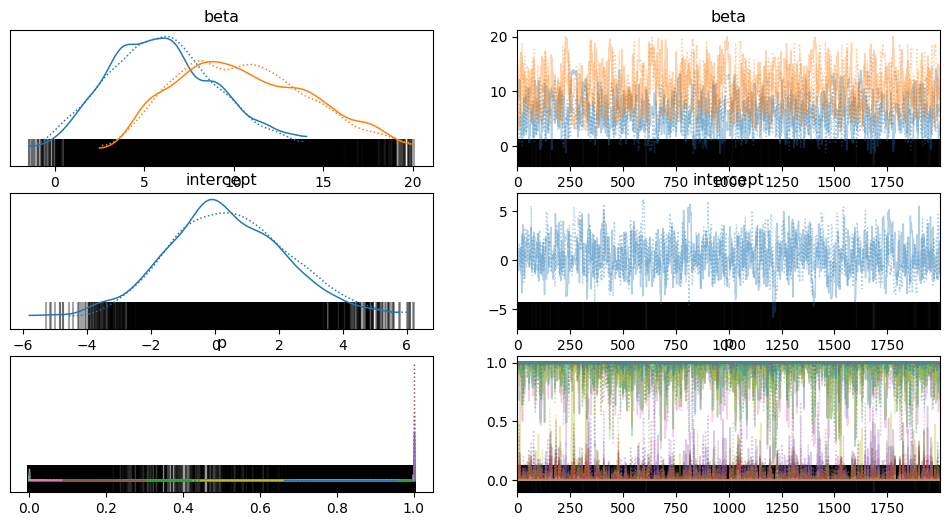


Decision Boundary (approx): <xarray.DataArray (beta_dim_0: 2)>
array([-0.0711912 , -0.04063857])
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 0 1


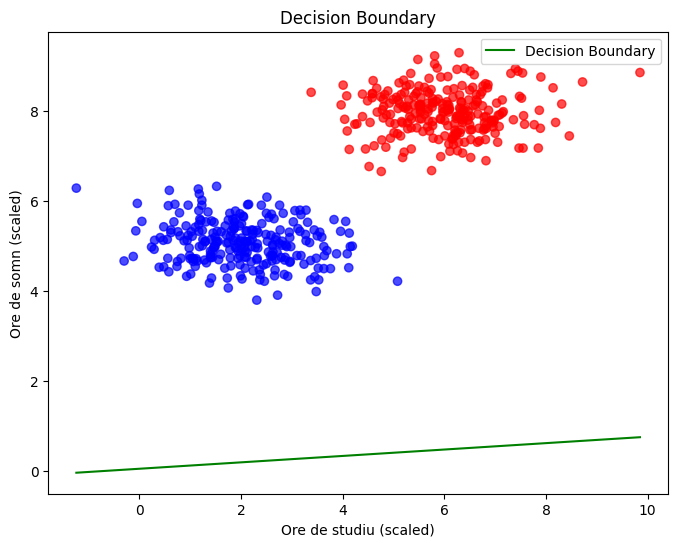


Relative Importance: 
Ore de studiu: 0.36, Ore de somn: 0.64


In [6]:
!pip install pymc3 arviz --quiet

import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

file_path = 'date_promovare_examen.csv'
data = pd.read_csv(file_path)

print("Dataset Overview:")
print(data.head())

print("\nClass Distribution:")
print(data['Promovare'].value_counts(normalize=True))

scaler = StandardScaler()
X = scaler.fit_transform(data[['Ore_Studiu', 'Ore_Somn']])
y = data['Promovare'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model pymc
with pm.Model() as logistic_model:
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    intercept = pm.Normal("intercept", mu=0, sigma=10)

    logits = intercept + pm.math.dot(X_train, beta)

    p = pm.Deterministic("p", pm.math.sigmoid(logits))
    observed = pm.Bernoulli("observed", p=p, observed=y_train)

    trace = pm.sample(2000, return_inferencedata=True, target_accept=0.95)

print("\nTrace Summary:")
print(az.summary(trace, hdi_prob=0.95))

az.plot_trace(trace)
plt.show()

decision_boundary = -trace.posterior["intercept"].mean() / trace.posterior["beta"].mean(axis=(0, 1))
print("\nDecision Boundary (approx):", decision_boundary)

plt.figure(figsize=(8, 6))
plt.scatter(data['Ore_Studiu'], data['Ore_Somn'], c=data['Promovare'], cmap='bwr', alpha=0.7)
x_vals = np.linspace(data['Ore_Studiu'].min(), data['Ore_Studiu'].max(), 100)

decision_boundary_values = decision_boundary.values

y_vals = -(decision_boundary_values[0] * x_vals + decision_boundary_values[1])

plt.plot(x_vals, y_vals, color='green', label='Decision Boundary')
plt.xlabel("Ore de studiu (scaled)")
plt.ylabel("Ore de somn (scaled)")
plt.title("Decision Boundary")
plt.legend()
plt.show()

beta_mean = trace.posterior["beta"].mean(axis=(0, 1))
importance = np.abs(beta_mean) / np.sum(np.abs(beta_mean))
print(f"\nRelative Importance: \nOre de studiu: {importance[0]:.2f}, Ore de somn: {importance[1]:.2f}")